# This Note Book is for Analysis of the User-Based Recommendations Framework

# Uploading the Data via Google (BX-Book-Ratings.csv)

## Or otherwise compute on Local Host

In [2]:
from google.colab import files

uploaded = files.upload()

# Libraries Used

In [0]:
import numpy as np   
import pandas as pd  

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib.pyplot as plt
import random

# Reading of the BX-Book-Ratings.csv Dataset

In [2]:
## Reading the CSV File.

# Reading this CSV is done a liitle differently as there is ";" instead ","(Comma).
# Postprocessing to make the proper Dataframe is in the next Cell. 

df = pd.read_csv('BX-Book-Ratings.csv',sep='delimiter') # Reading the CSV File

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [0]:
## Preprocessing to form the proper Dataset.

series = df['"User-ID";"ISBN";"Book-Rating"'].astype(str)  # Converting into Series to perform the operations

df = pd.DataFrame(series.str.split(';',expand=True)) # Splitting the Series(strings) with a delimeter (';')

df.columns = ['User-ID', 'ISBN', 'Ratings'] # Changing the Column Name

In [0]:
## Removing the  '""' from each column and converting them into intergers. 

df['User-ID'] = df['User-ID'].map(lambda x: x.lstrip('"').rstrip('"'))
df['ISBN'] = df['ISBN'].map(lambda x: x.lstrip('"').rstrip('"'))
df['Ratings'] = df['Ratings'].map(lambda x: x.lstrip('"').rstrip('"'))

df['User-ID'] = df['User-ID'].astype(int)
df['Ratings'] = df['Ratings'].astype(int)
df['ISBN'] = df['ISBN'].astype(str)

In [5]:
## Outputting the Ratings Data Frame

ratings_df = df

ratings_df.head()

,User-ID,ISBN,Ratings
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [6]:
print(ratings_df.shape)

(1149780, 3)


# Filtering the Dataset to a Small Dataset

## Users with less than 200 ratings and books with less than 100 ratings are excluded

In [7]:
## Filtering out impotant books to make the dataset smaller

# users with less than 200 ratings and books with less than 100 ratings are excluded

c = ratings_df['User-ID'].value_counts()

ratings_df = ratings_df[ratings_df['User-ID'].isin(c[c >= 200].index)]

c = ratings_df['Ratings'].value_counts()

ratings_df = ratings_df[ratings_df['Ratings'].isin(c[c >= 100].index)]

ratings_df.head()

,User-ID,ISBN,Ratings
1456,277427,002542730X,10
1457,277427,0026217457,0
1458,277427,003008685X,8
1459,277427,0030615321,0
1460,277427,0060002050,0


In [8]:
print(ratings_df.shape)

(527556, 3)


# Number of Users & Books

In [9]:
num_users = ratings_df['User-ID'].unique().shape[0]
num_books = ratings_df['ISBN'].unique().shape[0]
print(str(num_users) + ' users')
print(str(num_books) + ' books')

905 users
207699 books


# Splitting of Training and Testing Dataset

In [0]:
## For Splitting the data based on percentage

def data_splitter(ratings_df, percentage):
    m,n = ratings_df.shape
    V = round(m*(100-percentage)/100)
    A = ratings_df.copy()
    
    if percentage == 100:
        return A
    
    
    a = random.sample(range(ratings_df.shape[0]),V)
    
    A['Ratings'].iloc[a] = np.nan
    
    return A
  
def train_test_split(ratings_df,percentage):
  m,n = ratings_df.shape
  V = round(m*(100-percentage)/100)
  train = ratings_df.copy()


  a = random.sample(range(ratings_df.shape[0]),int(V))

  train['Ratings'].iloc[a] = np.nan
  
  
  test = train.copy()

  test = test.fillna(1000)
  
  test.ix[test['Ratings'] < 15, 'Ratings'] = np.nan

  test.ix[test['Ratings'] == 1000, 'Ratings'] = 0
  
  test['Ratings'] = test['Ratings'] + ratings_df['Ratings']
  
  
  return train,test

In [11]:
## Training Data (75%) of the Data

train_df,test_df = train_test_split(ratings_df, 75)

print(train_df.shape)

print(test_df.shape)


(527556, 3)
(527556, 3)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


# User Based Similarity Function

In [0]:
## Function for User-Based Recommendations

def UB_Reco(ratings_mat):
    print('The User-Based Recommendations Framework begins...')
    user_similarity = pairwise_distances(ratings_mat, metric='cosine')
    mean_user_rating = ratings_mat.mean(axis=1)
    ratings_diff = (ratings_mat - mean_user_rating[:, np.newaxis])
    pred = mean_user_rating[:, np.newaxis] + user_similarity.dot(ratings_diff) / np.array([np.abs(user_similarity).sum(axis=1)]).T
    print('The User-Based Recommendations Framework ends!')
    return pred

# MSE Calculation Function

In [0]:
## Function for MSE

def error(prediction, original):
    prediction = prediction[original.nonzero()].flatten()
    original = original[original.nonzero()].flatten()
    err = sqrt(mean_squared_error(prediction, original))
    print('Error is :'+ str(err))
    return err 

# Implementation of the Learning Curve

In [14]:
## Learning Curve Implementation

ERROR = []

for z in range(10):
    print('Starting Case ' + str((z+1)*10) + '%')
    A_df = data_splitter(train_df, (z+1)*10)
    A_df = A_df.pivot(index ='User-ID', columns ='ISBN', values ='Ratings').fillna(0)
    A_mat = A_df.values
    A_mat_hat = UB_Reco(A_mat)
    test_mat = test_df.pivot(index ='User-ID', columns ='ISBN', values ='Ratings').fillna(0).values
    Err = error(A_mat_hat, test_mat)
    ERROR.append(Err)
    print('Ending Case ' + str((z+1)*10) + '%')

Starting Case 10%


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


The User-Based Recommendations Framework begins...
The User-Based Recommendations Framework ends!
Error is :8.003279645385565
Ending Case 10%
Starting Case 20%
The User-Based Recommendations Framework begins...
The User-Based Recommendations Framework ends!
Error is :7.998400541839749
Ending Case 20%
Starting Case 30%
The User-Based Recommendations Framework begins...
The User-Based Recommendations Framework ends!
Error is :7.993072985173984
Ending Case 30%
Starting Case 40%
The User-Based Recommendations Framework begins...
The User-Based Recommendations Framework ends!
Error is :7.988384065438901
Ending Case 40%
Starting Case 50%
The User-Based Recommendations Framework begins...
The User-Based Recommendations Framework ends!
Error is :7.983585600109476
Ending Case 50%
Starting Case 60%
The User-Based Recommendations Framework begins...
The User-Based Recommendations Framework ends!
Error is :7.978786351077524
Ending Case 60%
Starting Case 70%
The User-Based Recommendations Framework

In [15]:
print(ERROR)

[8.003279645385565, 7.998400541839749, 7.993072985173984, 7.988384065438901, 7.983585600109476, 7.978786351077524, 7.973585918968411, 7.968690260397987, 7.963943313211335, 7.958996502442828]


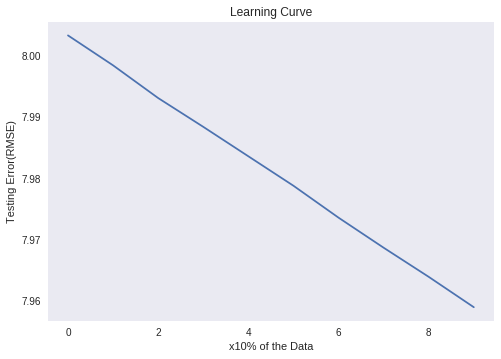

In [19]:
plt.plot(ERROR)
plt.xlabel('x10% of the Data')
plt.ylabel('Testing Error(RMSE)')
plt.title('Learning Curve')
plt.grid()
plt.show()